In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


In [3]:
# Read the metadata.csv file into a pandas DataFrame
# path = '/content/drive/My Drive/DukeStudies/548L_MLI_Project/Skin_Lesion_Classification/HAM10000data/'
path = '/content/drive/MyDrive/Sp23/BME548L_Machine_Learning_and_Imaging/548L_MLI_Project/Skin_Lesion_Classification/HAM10000data/'


#Model Training

In [4]:
metadata = pd.read_csv(path+'train_metadata.csv')

Now is processing the 1 th image
Progress: 0.0 %
Now is processing the 101 th image
Now is processing the 201 th image
Now is processing the 301 th image
Now is processing the 401 th image
Now is processing the 501 th image
Now is processing the 601 th image
Now is processing the 701 th image
Now is processing the 801 th image
Now is processing the 901 th image
Now is processing the 1001 th image
Progress: 10.0 %
Now is processing the 1101 th image
Now is processing the 1201 th image
Now is processing the 1301 th image
Now is processing the 1401 th image
Now is processing the 1501 th image
Now is processing the 1601 th image
Now is processing the 1701 th image
Now is processing the 1801 th image
Now is processing the 1901 th image
Now is processing the 2001 th image
Progress: 20.0 %
Now is processing the 2101 th image
Now is processing the 2201 th image
Now is processing the 2301 th image
Now is processing the 2401 th image
Now is processing the 2501 th image
Now is processing the 2601

(8012, 128, 128, 3)

(2003, 128, 128, 3)

(8012, 7)

(2003, 7)

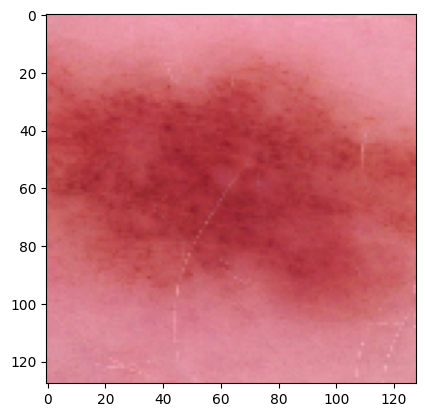

In [5]:
def load_and_crop(image, crop_size, normalized=True):
    width, height = image.size   # Get dimensions
    left = (width - crop_size)/2
    top = (height - crop_size)/2
    right = (width + crop_size)/2
    bottom = (height + crop_size)/2
    # Crop the center of the image
    # image = ImageOps.grayscale(image.crop((left, top, right, bottom)))
    image = image.crop((left, top, right, bottom))
    if normalized:
        return np.array(image).astype(np.float32) / 255.0
    else:
        return np.array(image).astype(np.float32)

# Load and preprocess the images
images = []
labels = []

for i, row in metadata.iterrows():
    image = load_img(row['image_path'], target_size=(150, 200))
    image = load_and_crop(image, 128)
    images.append(image)
    labels.append(row['dx'])

    if i % 100 == 0:
        print('Now is processing the', i+1, 'th image')
    if i % 1000 == 0:
        print('Progress:', i/100, '%')
    if i >= 10000:
        print('Progress:', i+1, '/10015')

# Convert the images and labels to numpy arrays and adding a fake color channel
X = np.array(images).reshape(-1, 128, 128, 3)
print(X.shape)
y = np.array(labels)
print(y.shape)

# Convert the labels to integer values
y = pd.Series(labels).factorize()[0]

# Convert the labels to one-hot encoded vectors
y = to_categorical(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

plt.imshow(X_train[0])

87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/35
401/401 [==============================] - 74s 62ms/step - loss: 5.3213 - accuracy: 0.6584 - val_loss: 4.2911 - val_accuracy: 0.7159
Epoch 2/35
401/401 [==============================] - 21s 51ms/step - loss: 3.5796 - accuracy: 0.7318 - val_loss: 2.9224 - val_accuracy: 0.7584
Epoch 3/35
401/401 [==============================] - 21s 51ms/step - loss: 2.4207 - accuracy: 0.7792 - val_loss: 2.1151 - val_accuracy: 0.7683
Epoch 4/35
401/401 [==============================] - 21s 52ms/step - loss: 1.6678 - accuracy: 0.8254 - val_loss: 1.5642 - val_accuracy: 0.7903
Epoch 5/35
401/401 [==============================] - 21s 51ms/step - loss: 1.1657 - accuracy: 0.8671 - val_loss: 1.2739 - val_accuracy: 0.7883
Epoch 6/35
401/401 [==============================] - 21s 51ms/step - loss: 0.8351 - accuracy: 0.9009 - val_loss: 1.1190 - val_accuracy: 0.7948
Epoch 7/35
401/401 [==============================] - 21s 51ms/step - l

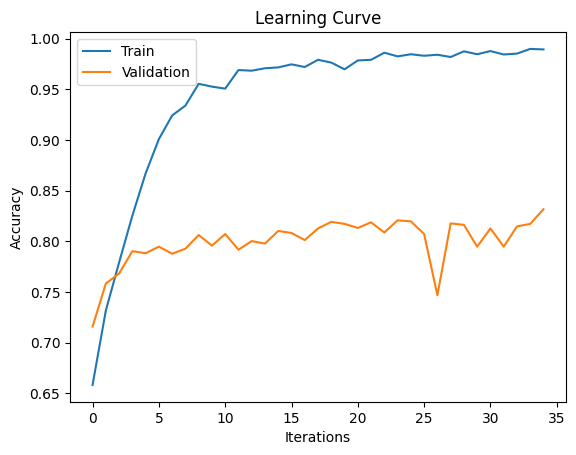

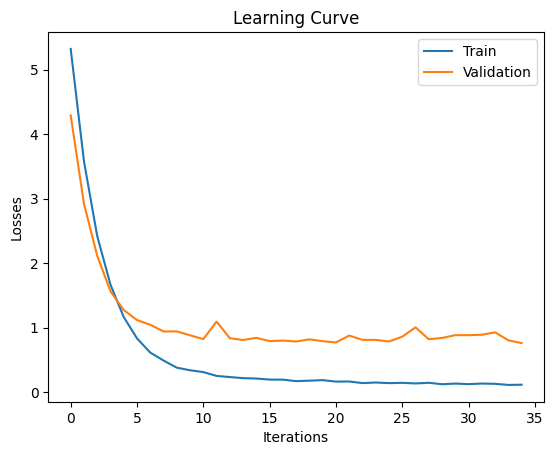

In [6]:
image_size = (128, 128, 3)

# Load the VGG16 model with imagenet weights
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg16.trainable = False

base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet',pooling='avg', input_shape=(128,128, 3))

model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.Input(image_size),
    
    base_model,
    Dropout(0.5),
    Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)),
    Dropout(0.5),
    Dense(7, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02))
    
    # # convolutional layers:
    # tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides = 1, activation='relu'),
    # tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides = 4, activation='relu'),
    # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 1, activation='relu'),
    # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 3, activation='relu'),

    # # dense layers:
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dense(7, activation='softmax')
])

# Compile the model with an Adam optimizer and cross-entropy loss function
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training set
hist = model.fit(X_train, y_train, batch_size=20, epochs=35, validation_data=(X_test, y_test))

plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('accuracy'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_accuracy'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('loss'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_loss'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Losses")
plt.legend(loc='best')
plt.show()

In [38]:
# Creat Fourier Mask
def create_mask(h, w, R_factor, r_factor): 
    center = (h//2, w//2) # use the middle of the image
    s = min(h, w)
    if R_factor <= 2:
        R_factor = 2
    R = round(s/R_factor)
    if R_factor >= r_factor:
        r = 0
    else:
        r = round(s/r_factor)

    X,Y = tf.meshgrid(tf.range(h), tf.range(w))

    dist_from_center = tf.sqrt(tf.cast((X - center[0])**2 + (Y-center[1])**2, dtype=tf.float32))

    mask = np.logical_and(dist_from_center >= r, dist_from_center < R)

    return mask

In [45]:
class FourierFilter(tf.keras.layers.Layer):
    def __init__(self):
        super(FourierFilter, self).__init__()
        
    def build(self, input_shape):
        # Setting up shape parameters
        _, self.h, self.w, self.c = input_shape
        self.R_factor = 10 #@param {type:"slider", min:0, max:100, step:5}
        self.r_factor = 250 #@param {type:"slider", min:0, max:1000, step:10}
        
        # self.R_factor = self.add_weight(name='R_factor', shape=(1,), initializer='uniform', trainable=True)
        # self.r_factor = self.add_weight(name='r_factor', shape=(1,), initializer='uniform', trainable=True)
       
        # Defining the mask in the layer
        mask = create_mask(self.h, self.w, self.R_factor, self.r_factor)
        mask = tf.cast(mask, dtype=tf.complex64)
        self.mask = mask
        
    def get_mask(self):
        return self.mask
            
    def call(self, inputs):
        # Apply 2D Fourier transform to each channel
        inputs = tf.cast(inputs, dtype=tf.complex64)
        inputs = tf.transpose(inputs, perm=[0, 3, 1, 2])
        inputs_fft = tf.signal.fft2d(inputs)
        inputs_fft = tf.signal.fftshift(inputs_fft)
                
        # Apply circular mask
        inputs_fft *= self.mask
        
        # Apply 2D inverse Fourier transform
        inputs_filtered = tf.signal.ifftshift(inputs_fft)
        inputs_filtered = tf.signal.ifft2d(inputs_filtered)
        inputs_filtered = tf.cast(inputs_filtered, dtype=tf.complex64)
        inputs_filtered = tf.abs(inputs_filtered)
        inputs_filtered = tf.transpose(inputs_filtered, perm=[0,2,3,1])
        
        return inputs_filtered

In [46]:
# Create new weighted RGB image
import tensorflow.keras.backend as K

class WeightedRGBLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(WeightedRGBLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Define the trainable weights for the RGB channels
        self.r_weights = self.add_weight(name='r_weights', shape=(1,), initializer='uniform', trainable=True)
        self.g_weights = self.add_weight(name='g_weights', shape=(1,), initializer='uniform', trainable=True)
        self.b_weights = self.add_weight(name='b_weights', shape=(1,), initializer='uniform', trainable=True)

    def call(self, inputs):
        # Split the input image into its RGB channels
        r, g, b = tf.split(inputs, num_or_size_splits=3, axis=-1)

        # Scale the RGB channels by the trainable weights
        r_scaled = r * self.r_weights
        g_scaled = g * self.g_weights
        b_scaled = b * self.b_weights

        # Merge the scaled RGB channels into an image
        merged = tf.concat([r_scaled, g_scaled, b_scaled], axis=-1)
        merged = tf.cast(merged, dtype=tf.float32)

        return merged

    def compute_output_shape(self, input_shape):
        return input_shape

In [47]:
class PlotLayerOutputCallback(tf.keras.callbacks.Callback):
    def __init__(self, layer_index, img, plot_freq=5):
        super(PlotLayerOutputCallback, self).__init__()
        self.layer_index = layer_index
        self.plot_freq = plot_freq
        self.img = img
        
    def on_epoch_end(self, epoch, logs=None):
        
        # if epoch == 0:
        if (epoch+1) % self.plot_freq == 0:
            layer_output_func = tf.keras.backend.function([self.model.layers[0].input],
                                                           [self.model.layers[self.layer_index].output])
            layer_output = layer_output_func(self.img)[0] * 255
            plt.imshow(layer_output[0])
            plt.show()

plot_callback = PlotLayerOutputCallback(layer_index = 0, plot_freq = 5, img = X_train[0:2])

In [48]:
model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.Input(image_size),
    
    # RGB regenerate layer
    WeightedRGBLayer(),

    # FFT layer
    FourierFilter(),
    

    base_model,
    Dropout(0.5),
    Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)),
    Dropout(0.5),
    Dense(7, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02))
    
    # # convolutional layers:
    # tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides = 1, activation='relu'),
    # tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides = 4, activation='relu'),
    # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 1, activation='relu'),
    # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 3, activation='relu'),

    # # dense layers:
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dense(7, activation='softmax')
])

# Compile the model with an Adam optimizer and cross-entropy loss function
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 weighted_rgb_layer_7 (Weigh  (None, 128, 128, 3)      3         
 tedRGBLayer)                                                    
                                                                 
 fourier_filter_7 (FourierFi  (None, 128, 128, 3)      0         
 lter)                                                           
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dropout_16 (Dropout)        (None, 2048)              0         
                                                                 
 dense_16 (Dense)            (None, 128)               262272    
                                                                 
 dropout_17 (Dropout)        (None, 128)              

Epoch 1/35


401/401 [==============================] - 60s 60ms/step - loss: 4.9673 - accuracy: 0.7706 - val_loss: 4.5416 - val_accuracy: 0.6680
Epoch 2/35
401/401 [==============================] - 22s 55ms/step - loss: 2.9158 - accuracy: 0.9161 - val_loss: 3.4553 - val_accuracy: 0.7079
Epoch 3/35
401/401 [==============================] - 22s 55ms/step - loss: 1.6768 - accuracy: 0.9699 - val_loss: 2.5570 - val_accuracy: 0.6645
Epoch 4/35
401/401 [==============================] - 22s 55ms/step - loss: 1.0236 - accuracy: 0.9742 - val_loss: 2.3121 - val_accuracy: 0.7139
Epoch 5/35
401/401 [==============================] - ETA: 0s - loss: 0.6281 - accuracy: 0.9860

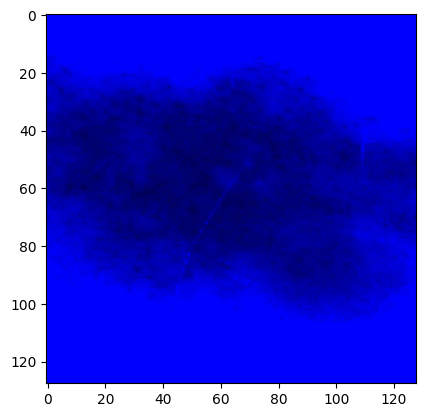

401/401 [==============================] - 22s 56ms/step - loss: 0.6281 - accuracy: 0.9860 - val_loss: 2.8612 - val_accuracy: 0.6855
Epoch 6/35
401/401 [==============================] - 22s 56ms/step - loss: 0.4150 - accuracy: 0.9886 - val_loss: 1.9552 - val_accuracy: 0.7124
Epoch 7/35
401/401 [==============================] - 22s 56ms/step - loss: 0.3023 - accuracy: 0.9873 - val_loss: 1.8077 - val_accuracy: 0.6850
Epoch 8/35
401/401 [==============================] - 22s 56ms/step - loss: 0.2342 - accuracy: 0.9855 - val_loss: 1.3841 - val_accuracy: 0.7174
Epoch 9/35
401/401 [==============================] - 23s 56ms/step - loss: 0.1792 - accuracy: 0.9891 - val_loss: 1.6700 - val_accuracy: 0.7159
Epoch 10/35
401/401 [==============================] - ETA: 0s - loss: 0.1577 - accuracy: 0.9881

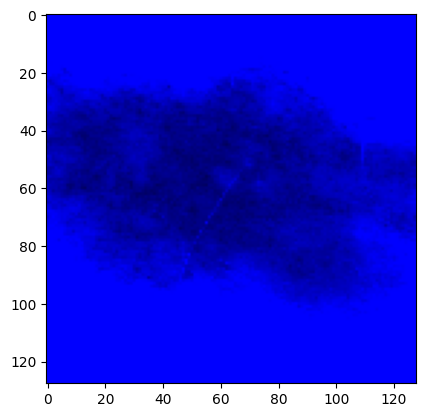

401/401 [==============================] - 23s 57ms/step - loss: 0.1577 - accuracy: 0.9881 - val_loss: 1.3467 - val_accuracy: 0.7304
Epoch 11/35
401/401 [==============================] - 22s 56ms/step - loss: 0.1345 - accuracy: 0.9894 - val_loss: 1.3125 - val_accuracy: 0.7314
Epoch 12/35
401/401 [==============================] - 22s 56ms/step - loss: 0.1113 - accuracy: 0.9940 - val_loss: 1.2715 - val_accuracy: 0.7389
Epoch 13/35
401/401 [==============================] - 22s 56ms/step - loss: 0.1200 - accuracy: 0.9904 - val_loss: 1.5469 - val_accuracy: 0.7159
Epoch 14/35
401/401 [==============================] - 23s 56ms/step - loss: 0.1222 - accuracy: 0.9894 - val_loss: 1.3181 - val_accuracy: 0.7464
Epoch 15/35
401/401 [==============================] - ETA: 0s - loss: 0.1059 - accuracy: 0.9918

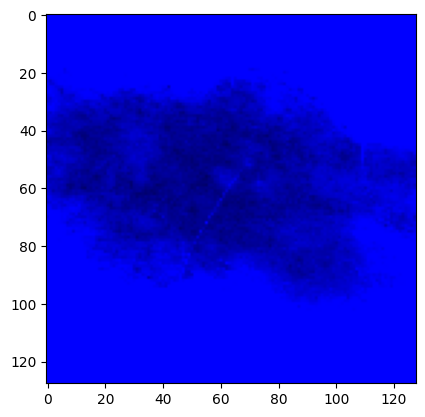

401/401 [==============================] - 23s 56ms/step - loss: 0.1059 - accuracy: 0.9918 - val_loss: 1.1750 - val_accuracy: 0.7379
Epoch 16/35
401/401 [==============================] - 22s 56ms/step - loss: 0.1074 - accuracy: 0.9915 - val_loss: 1.2548 - val_accuracy: 0.7454
Epoch 17/35
401/401 [==============================] - 22s 56ms/step - loss: 0.1058 - accuracy: 0.9911 - val_loss: 1.3313 - val_accuracy: 0.7424
Epoch 18/35
401/401 [==============================] - 23s 56ms/step - loss: 0.1204 - accuracy: 0.9864 - val_loss: 1.3350 - val_accuracy: 0.7049
Epoch 19/35
401/401 [==============================] - 22s 56ms/step - loss: 0.1037 - accuracy: 0.9925 - val_loss: 1.2079 - val_accuracy: 0.7464
Epoch 20/35
401/401 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9958

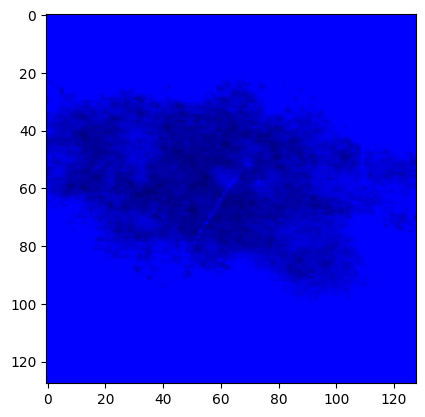

401/401 [==============================] - 23s 56ms/step - loss: 0.0859 - accuracy: 0.9958 - val_loss: 1.2552 - val_accuracy: 0.7359
Epoch 21/35
401/401 [==============================] - 22s 55ms/step - loss: 0.0944 - accuracy: 0.9931 - val_loss: 1.2168 - val_accuracy: 0.7369
Epoch 22/35
401/401 [==============================] - 22s 56ms/step - loss: 0.0976 - accuracy: 0.9919 - val_loss: 1.4031 - val_accuracy: 0.7284
Epoch 23/35
401/401 [==============================] - 22s 55ms/step - loss: 0.1135 - accuracy: 0.9888 - val_loss: 1.2104 - val_accuracy: 0.7459
Epoch 24/35
401/401 [==============================] - 22s 56ms/step - loss: 0.0953 - accuracy: 0.9926 - val_loss: 1.3454 - val_accuracy: 0.7374
Epoch 25/35
401/401 [==============================] - ETA: 0s - loss: 0.0917 - accuracy: 0.9941

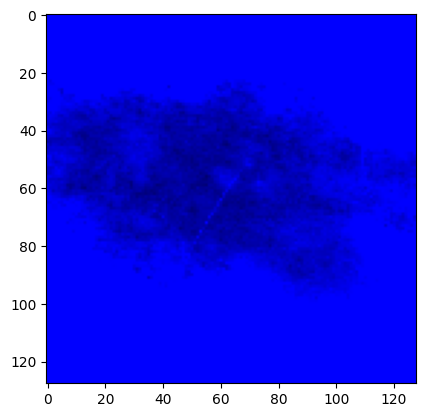

401/401 [==============================] - 23s 56ms/step - loss: 0.0917 - accuracy: 0.9941 - val_loss: 1.1195 - val_accuracy: 0.7459
Epoch 26/35
401/401 [==============================] - 22s 56ms/step - loss: 0.0889 - accuracy: 0.9930 - val_loss: 1.2884 - val_accuracy: 0.7204
Epoch 27/35
401/401 [==============================] - 22s 56ms/step - loss: 0.1050 - accuracy: 0.9890 - val_loss: 1.1881 - val_accuracy: 0.7414
Epoch 28/35
401/401 [==============================] - 22s 55ms/step - loss: 0.0855 - accuracy: 0.9946 - val_loss: 1.1656 - val_accuracy: 0.7409
Epoch 29/35
401/401 [==============================] - 22s 56ms/step - loss: 0.0824 - accuracy: 0.9955 - val_loss: 1.1989 - val_accuracy: 0.7499
Epoch 30/35
401/401 [==============================] - ETA: 0s - loss: 0.0852 - accuracy: 0.9944

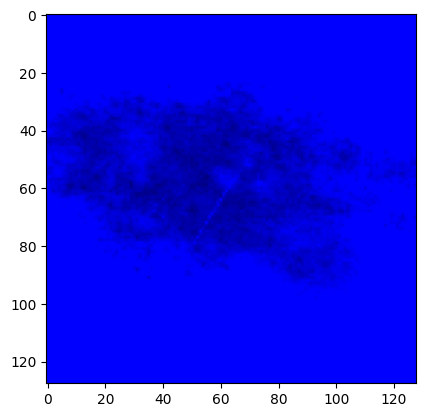

401/401 [==============================] - 22s 55ms/step - loss: 0.0852 - accuracy: 0.9944 - val_loss: 1.2465 - val_accuracy: 0.7454
Epoch 31/35
401/401 [==============================] - 22s 56ms/step - loss: 0.1089 - accuracy: 0.9888 - val_loss: 1.3469 - val_accuracy: 0.7279
Epoch 32/35
401/401 [==============================] - 22s 56ms/step - loss: 0.0845 - accuracy: 0.9941 - val_loss: 1.2897 - val_accuracy: 0.7449
Epoch 33/35
401/401 [==============================] - 22s 55ms/step - loss: 0.0847 - accuracy: 0.9945 - val_loss: 1.1672 - val_accuracy: 0.7589
Epoch 34/35
401/401 [==============================] - 22s 56ms/step - loss: 0.0741 - accuracy: 0.9964 - val_loss: 1.2194 - val_accuracy: 0.7569
Epoch 35/35
400/401 [============================>.] - ETA: 0s - loss: 0.0822 - accuracy: 0.9940

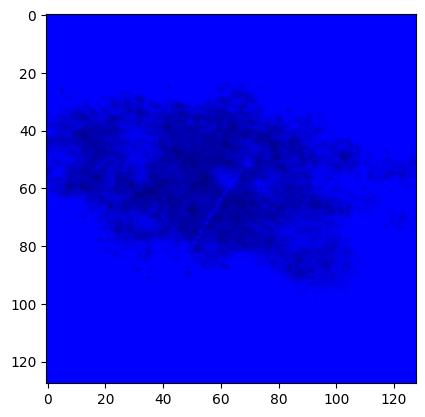

401/401 [==============================] - 22s 56ms/step - loss: 0.0821 - accuracy: 0.9940 - val_loss: 1.1697 - val_accuracy: 0.7559


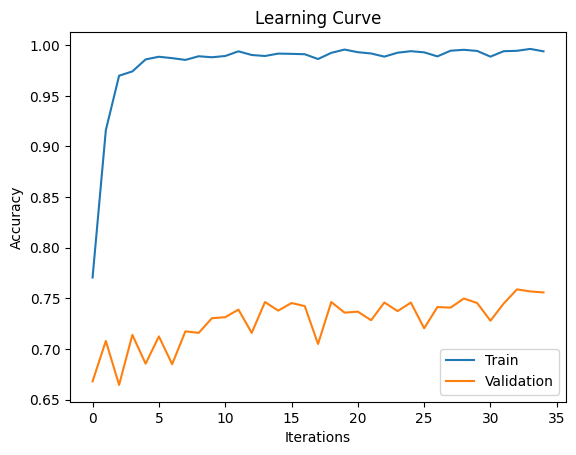

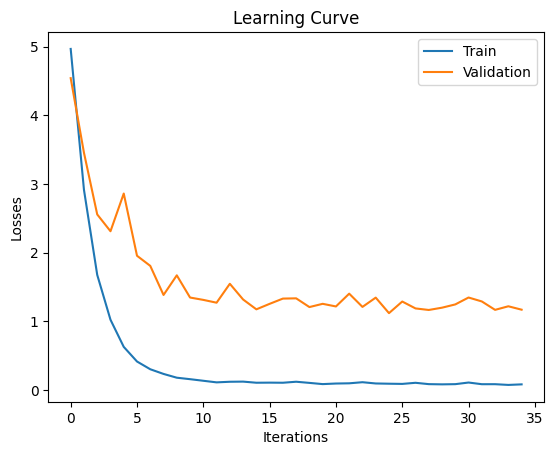

In [50]:
# Train model with callback
hist = model.fit(X_train, y_train, batch_size=20, epochs=35, validation_data=(X_test, y_test), callbacks=[plot_callback])

plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('accuracy'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_accuracy'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('loss'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_loss'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Losses")
plt.legend(loc='best')
plt.show()